**Import all libraries**

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, EfficientNetB7, ResNet50
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

**Hyperparameter**

In [2]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

In [3]:
def plot_image(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()

In [43]:
def evaluate_model_predictions(model, generator, class_indices, title="Confusion Matrix"):
    """
    Evaluates model predictions and generates a confusion matrix visualization.

    Parameters:
    - model: Trained model used for predictions.
    - generator: Validation or test data generator.
    - class_indices: Dictionary mapping class names to indices.
    - title (str): Title for the confusion matrix plot.

    Returns:
    - conf_matrix (numpy.ndarray): The computed confusion matrix.
    """
    # Generate predictions
    predicted_classes = model.predict(generator, verbose=1)
    predicted_classes = np.argmax(predicted_classes, axis=1)

    # Get true labels
    true_classes = generator.classes

    # Check lengths match
    if len(true_classes) != len(predicted_classes):
        print("Mismatch in the number of samples between true classes and predicted classes.")
        return None

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=class_indices.keys(), 
        yticklabels=class_indices.keys()
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

    return conf_matrix

In [51]:
def generate_classification_report(model, generator, class_indices):
    """
    Generates a classification report for model predictions.

    Parameters:
    - model: Trained model used for predictions.
    - generator: Validation or test data generator.
    - class_indices: Dictionary mapping class names to indices.

    Returns:
    - report (str): The classification report as a string.
    """
    # Generate predictions
    predicted_classes = model.predict(generator, verbose=1)
    predicted_classes = np.argmax(predicted_classes, axis=1)

    # Get true labels
    true_classes = generator.classes

    # Check lengths match
    if len(true_classes) != len(predicted_classes):
        print("Mismatch in the number of samples between true classes and predicted classes.")
        return None

    # Generate classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_indices.keys())
    

    return report


**Callbacks**

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.5,              
    patience=3,            
    verbose=1,                
    min_lr=1e-6               
)

early_stopping = EarlyStopping(monitor='val_loss',patience=3, restore_best_weights=True) 

# **Load dataset** 

In [4]:
dataset_path = "/kaggle/input/face-shape-3classes/face-shape-new"

print('List dir:')
for file in os.listdir(dataset_path):
  print(file)

List dir:
test_set
training_set


In [5]:
train_dir = os.path.join(dataset_path, 'training_set')
test_dir = os.path.join(dataset_path, 'test_set')

# **Data preprocessing & augmentation**

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          
    rotation_range=20,      
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True,   
    fill_mode='nearest'     
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [8]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
        )

Found 4819 images belonging to 3 classes.
Found 1254 images belonging to 3 classes.


# **Model Train**

**VGG16**

In [9]:
vgg16_model = VGG16(
    input_shape=(224, 224, 3),           
    include_top=False,                   
    weights='imagenet',
    pooling='max'
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Open 4 last layer for fine tuning

In [11]:
for layer in vgg16_model.layers[-4:]: 
    layer.trainable = True

In [ ]:
x = Flatten()(vgg16_model.output) 
x = Dense(256, activation='relu')(x)  
x = Dropout(0.2)(x)  
x = Dense(128, activation='relu')(x)  
x = Dropout(0.2)(x) 
x = Dense(64, activation='relu')(x)  
x = Dropout(0.4)(x) 
x = Dense(3, activation='softmax')(x) 

tl1_model = Model(inputs=vgg16_model.input, outputs=x)

tl1_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
tl1_model.summary()

In [17]:
history1 = tl1_model.fit(
    train_generator,
    validation_data=validation_generator,  
    epochs=50,
    verbose=2,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733190995.339162     133 service.cc:145] XLA service 0x7f19e80023f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733190995.339222     133 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733190995.339227     133 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733191036.142663     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/151 - 160s - 1s/step - accuracy: 0.3318 - loss: 1.1344 - val_accuracy: 0.3357 - val_loss: 1.0954 - learning_rate: 1.0000e-04
Epoch 2/50
151/151 - 84s - 554ms/step - accuracy: 0.3355 - loss: 1.1094 - val_accuracy: 0.3939 - val_loss: 1.0909 - learning_rate: 1.0000e-04
Epoch 3/50
151/151 - 84s - 557ms/step - accuracy: 0.3455 - loss: 1.1057 - val_accuracy: 0.3541 - val_loss: 1.0926 - learning_rate: 1.0000e-04
Epoch 4/50
151/151 - 84s - 558ms/step - accuracy: 0.3536 - loss: 1.1001 - val_accuracy: 0.3892 - val_loss: 1.0869 - learning_rate: 1.0000e-04
Epoch 5/50
151/151 - 84s - 556ms/step - accuracy: 0.3548 - loss: 1.1034 - val_accuracy: 0.3780 - val_loss: 1.0954 - learning_rate: 1.0000e-04
Epoch 6/50
151/151 - 84s - 557ms/step - accuracy: 0.3575 - loss: 1.0986 - val_accuracy: 0.3317 - val_loss: 1.0946 - learning_rate: 1.0000e-04
Epoch 7/50
151/151 - 84s - 555ms/step - accuracy: 0.3567 - loss: 1.0949 - val_accuracy: 0.3939 - val_loss: 1.0823 - learning_rate: 1.0000e-04
Epoch 8/50
151/151 

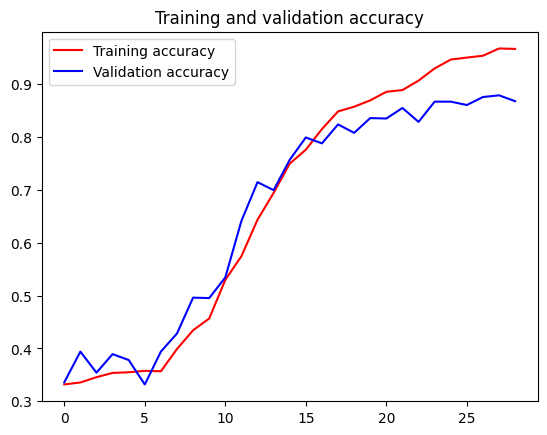

<Figure size 640x480 with 0 Axes>

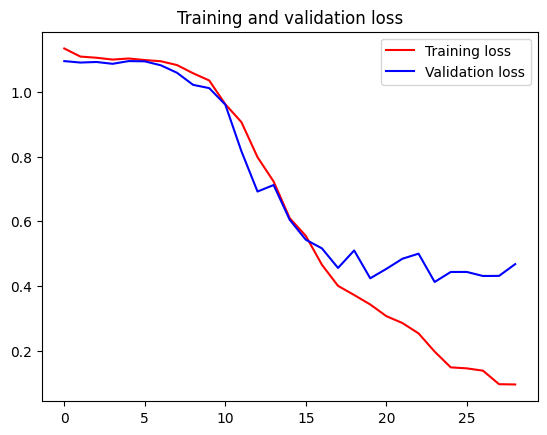

<Figure size 640x480 with 0 Axes>

In [18]:
plot_image(history1)

**Resnet50**

In [26]:
r50_model = ResNet50(
    input_shape=(224, 224, 3),           
    include_top=False,                   
    weights='imagenet'             
)

In [27]:
for layer in r50_model.layers[-4:]: 
    layer.trainable = True

In [37]:
x = Flatten()(r50_model.output) 
x = Dense(256, activation='relu')(x)  
x = Dropout(0.2)(x)  
x = Dense(128, activation='relu')(x)  
x = Dropout(0.2)(x) 
x = Dense(64, activation='relu')(x)  
x = Dropout(0.4)(x) 
x = Dense(3, activation='softmax')(x) 

tl2_model = Model(inputs=r50_model.input, outputs=x)

tl2_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
tl2_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,319,427 (188.14 MB)

 Trainable params: 49,266,307 (187.94 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [39]:
history2 = tl2_model.fit(
    train_generator,
    validation_data=validation_generator,  
    epochs=50,
    verbose=2,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/50


I0000 00:00:1733194788.701612     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_28', 20 bytes spill stores, 20 bytes spill loads



151/151 - 145s - 959ms/step - accuracy: 0.4071 - loss: 1.3054 - val_accuracy: 0.3796 - val_loss: 1.1004 - learning_rate: 1.0000e-04
Epoch 2/50
151/151 - 64s - 425ms/step - accuracy: 0.5439 - loss: 0.9793 - val_accuracy: 0.3541 - val_loss: 1.1093 - learning_rate: 1.0000e-04
Epoch 3/50
151/151 - 64s - 426ms/step - accuracy: 0.6337 - loss: 0.8334 - val_accuracy: 0.3469 - val_loss: 1.2385 - learning_rate: 1.0000e-04
Epoch 4/50
151/151 - 62s - 411ms/step - accuracy: 0.7045 - loss: 0.7125 - val_accuracy: 0.5000 - val_loss: 1.0279 - learning_rate: 1.0000e-04
Epoch 5/50
151/151 - 66s - 437ms/step - accuracy: 0.7649 - loss: 0.6119 - val_accuracy: 0.6555 - val_loss: 0.8462 - learning_rate: 1.0000e-04
Epoch 6/50
151/151 - 67s - 441ms/step - accuracy: 0.8024 - loss: 0.5376 - val_accuracy: 0.5797 - val_loss: 1.0824 - learning_rate: 1.0000e-04
Epoch 7/50
151/151 - 63s - 418ms/step - accuracy: 0.8274 - loss: 0.4664 - val_accuracy: 0.7703 - val_loss: 0.5344 - learning_rate: 1.0000e-04
Epoch 8/50
151/1

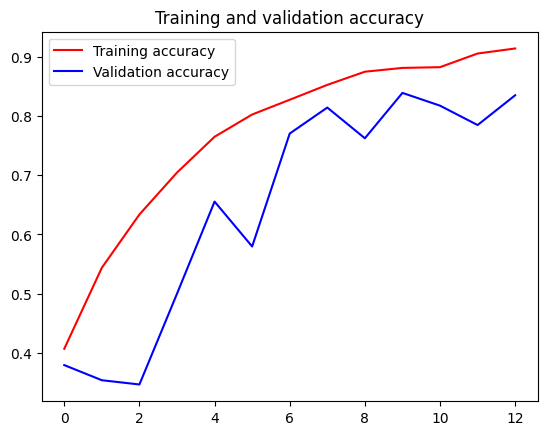

<Figure size 640x480 with 0 Axes>

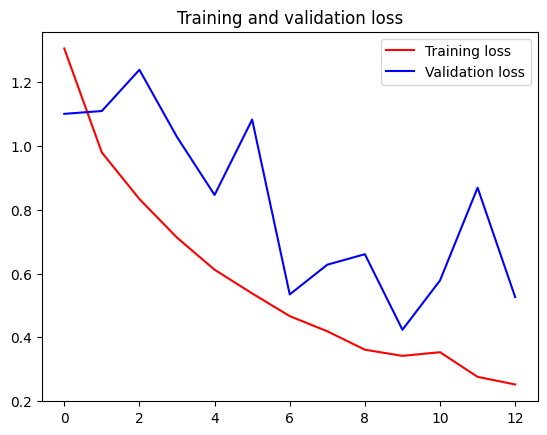

<Figure size 640x480 with 0 Axes>

In [40]:
plot_image(history2)

**EfficientNetB7**

In [ ]:
enb7_model = EfficientNetB7(
    input_shape=(224, 224, 3),           
    include_top=False,                   
    weights='imagenet',
    pool='max'
)

In [ ]:
for layer in enb7_model.layers[-4:]: 
    layer.trainable = True

In [ ]:
x = Flatten()(enb7_model.output) 
x = Dense(256, activation='relu')(x)  
x = Dropout(0.2)(x)  
x = Dense(128, activation='relu')(x)  
x = Dropout(0.2)(x) 
x = Dense(64, activation='relu')(x)  
x = Dropout(0.4)(x) 
x = Dense(3, activation='softmax')(x) 

tl3_model = Model(inputs=enb7_model.input, outputs=x)

tl3_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
tl3_model.summary()

In [ ]:
history3 = tl3_model.fit(
    train_generator,
    validation_data=validation_generator,  
    epochs=50,
    verbose=2,
    callbacks=[early_stopping, reduce_lr])

# **Model Evaluation** 

**VGG16**

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step


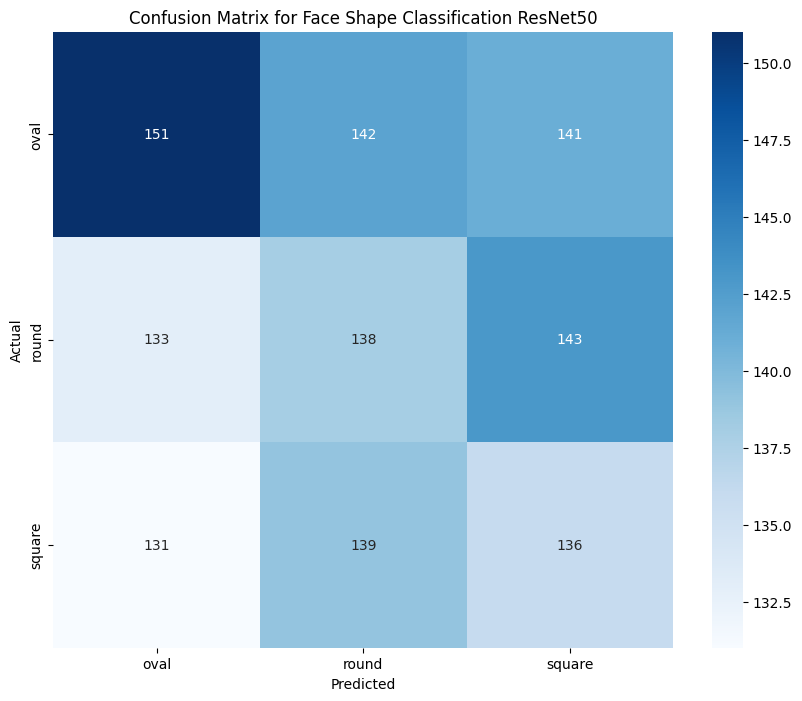

array([[151, 142, 141],
       [133, 138, 143],
       [131, 139, 136]])

In [54]:
evaluate_model_predictions(
    model=tl1_model,
    generator=validation_generator,
    class_indices=validation_generator.class_indices,
    title="Confusion Matrix for Face Shape Classification ResNet50"
)

In [55]:
print(generate_classification_report(
    model=tl1_model,
    generator=validation_generator,
    class_indices=validation_generator.class_indices
))

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step
              precision    recall  f1-score   support

        oval       0.34      0.32      0.33       434
       round       0.32      0.33      0.32       414
      square       0.32      0.33      0.32       406

    accuracy                           0.33      1254
   macro avg       0.33      0.33      0.33      1254
weighted avg       0.33      0.33      0.33      1254



**ResNet50**

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step


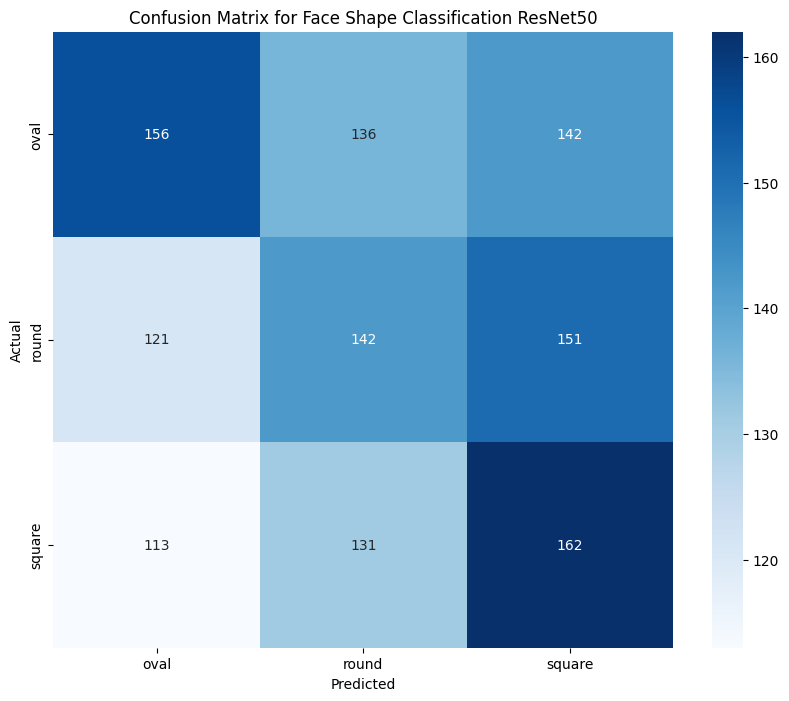

array([[156, 136, 142],
       [121, 142, 151],
       [113, 131, 162]])

In [46]:
evaluate_model_predictions(
    model=tl2_model,
    generator=validation_generator,
    class_indices=validation_generator.class_indices,
    title="Confusion Matrix for Face Shape Classification ResNet50"
)

In [53]:
print(generate_classification_report(
    model=tl2_model,
    generator=validation_generator,
    class_indices=validation_generator.class_indices
))


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step
              precision    recall  f1-score   support

        oval       0.33      0.29      0.31       434
       round       0.33      0.33      0.33       414
      square       0.31      0.34      0.33       406

    accuracy                           0.32      1254
   macro avg       0.32      0.32      0.32      1254
weighted avg       0.32      0.32      0.32      1254



**EfficientNetB7**

In [ ]:
evaluate_model_predictions(
    model=tl3_model,
    generator=validation_generator,
    class_indices=validation_generator.class_indices,
    title="Confusion Matrix for Face Shape Classification ResNet50"
)

In [ ]:
print(generate_classification_report(
    model=tl3_model,
    generator=validation_generator,
    class_indices=validation_generator.class_indices
))
